Cached stim: /auto/data/tmp/tstim/NaturalSounds-2-0.5-3-1-White______-100-0-3__8-65dB-ozgf-fs100-ch18-incps1.mat
Spike file: /auto/data/daq/Tartufo/TAR010/sorted/TAR010c16_p_NAT.spk.mat
rounding Trial offset spike times to even number of rasterfs bins
342 trials totaling 2076.12 sec
Creating trial events
Creating trial outcome events
Removing post-response stimuli
Keeping 2394/2394 events that precede responses
Fetching ins & outs...

Elapsed fitting time : 6.596358060836792


/home/alexis/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


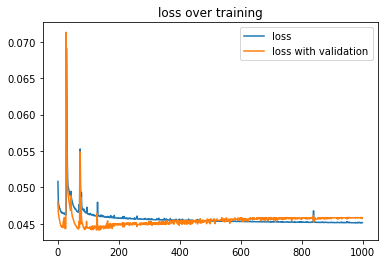

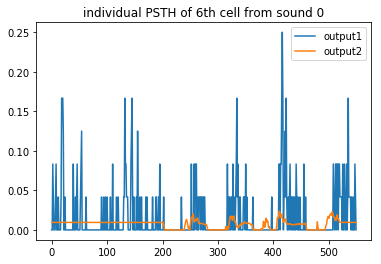

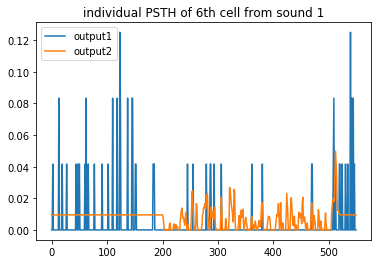

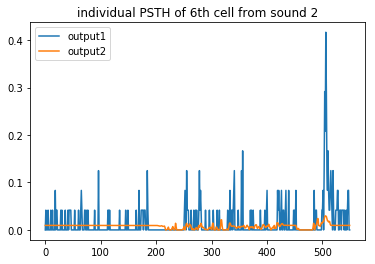

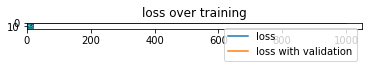

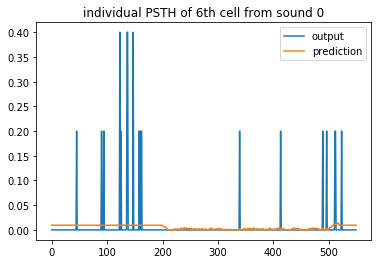

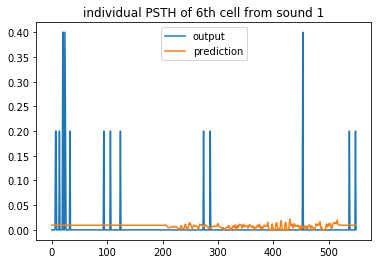

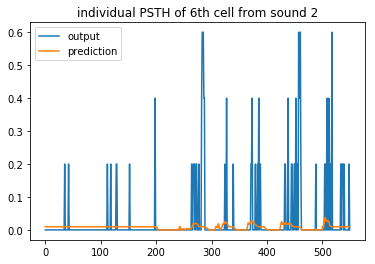

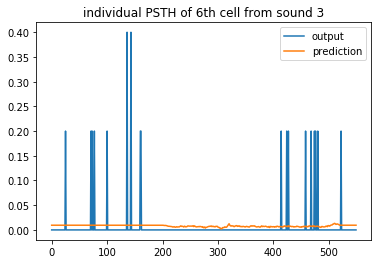

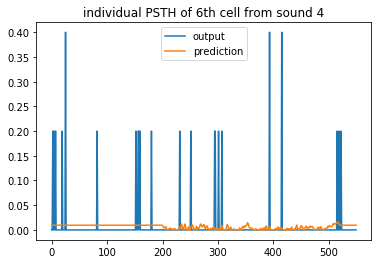

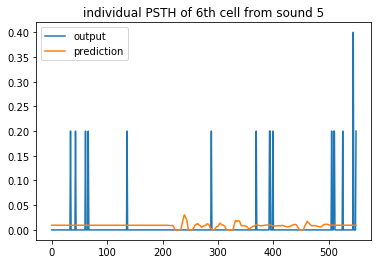

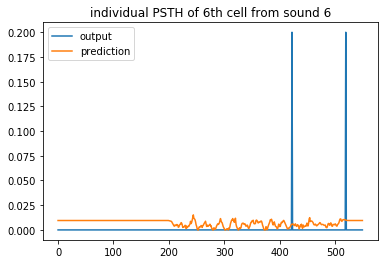

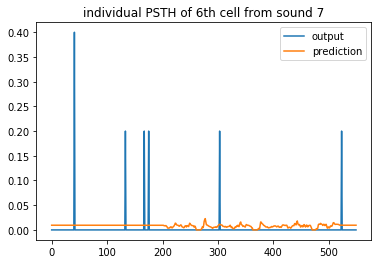

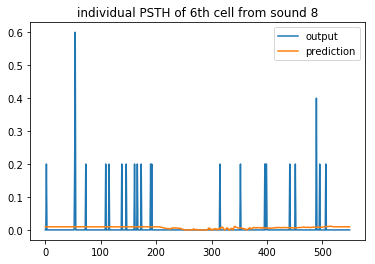

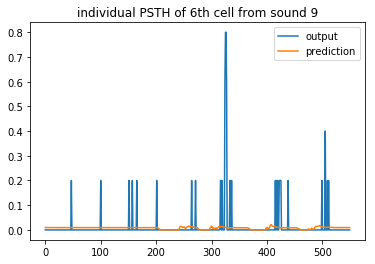

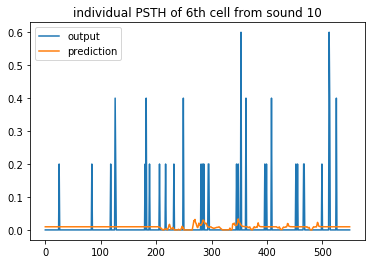

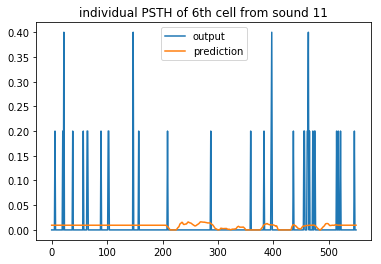

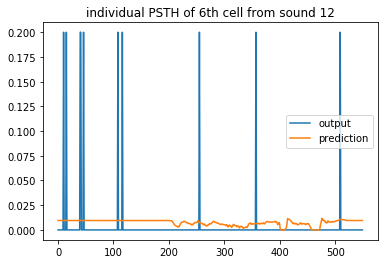

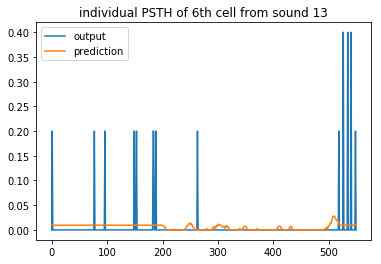

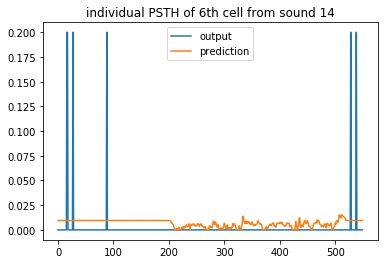

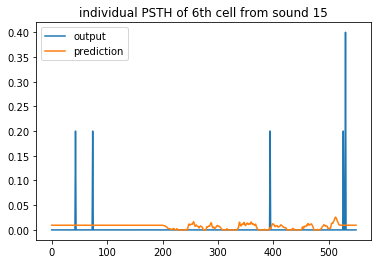

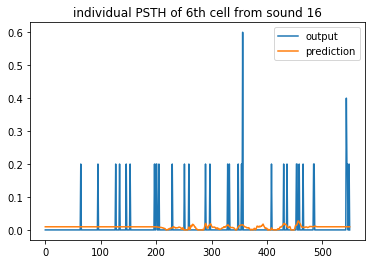

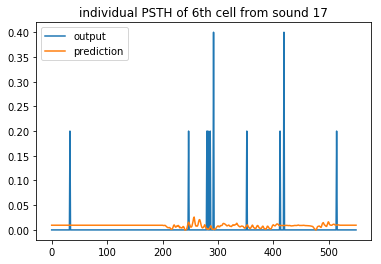

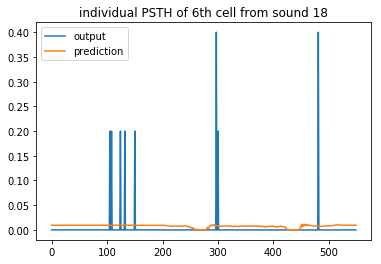

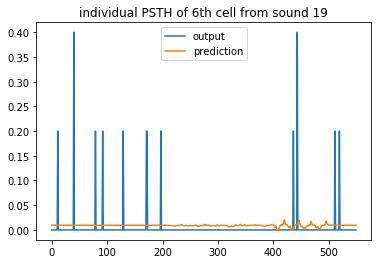

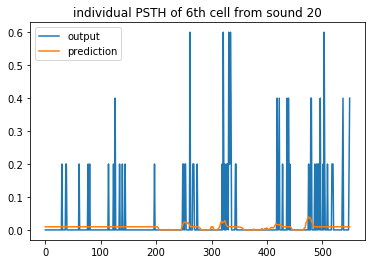

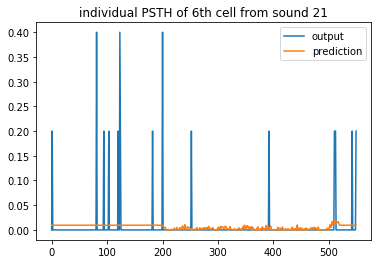

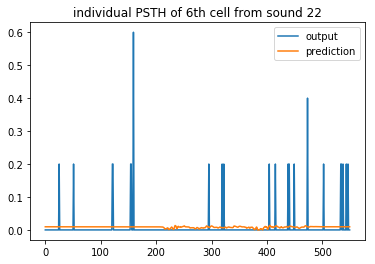

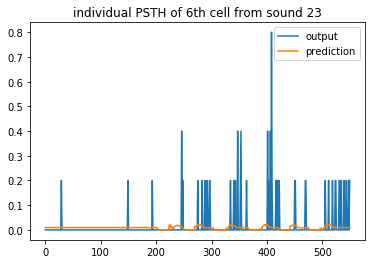

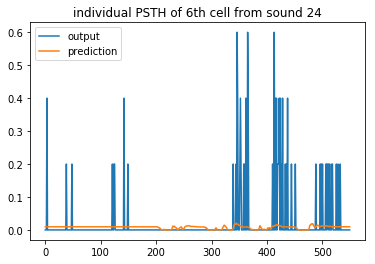

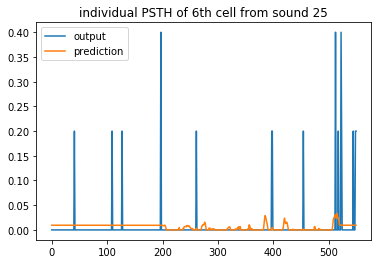

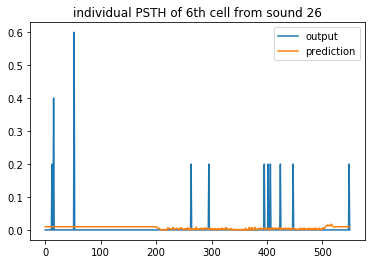

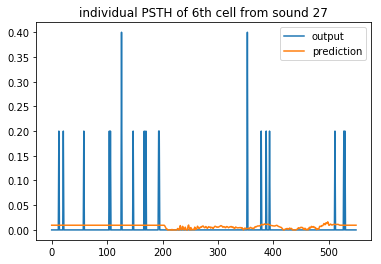

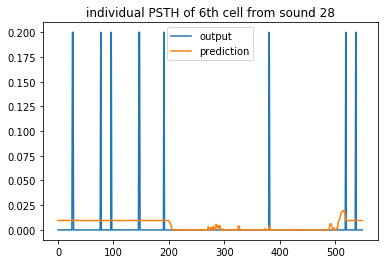

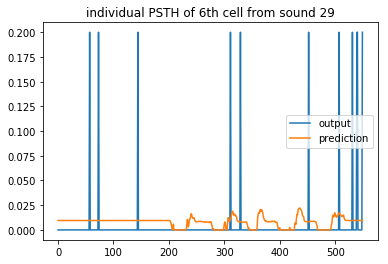

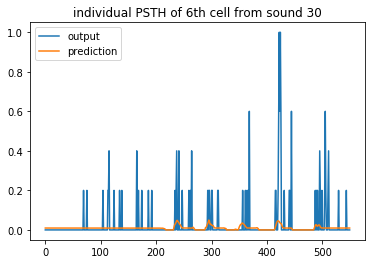

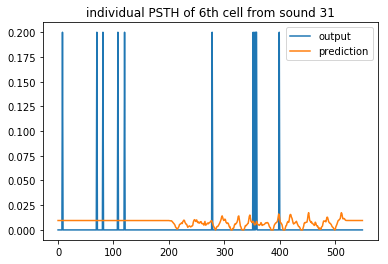

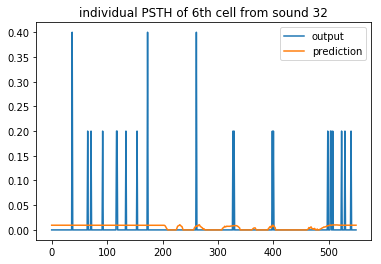

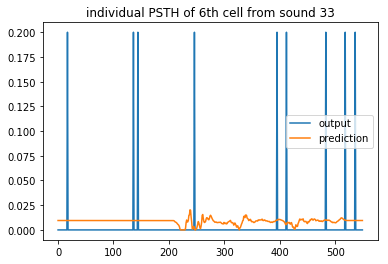

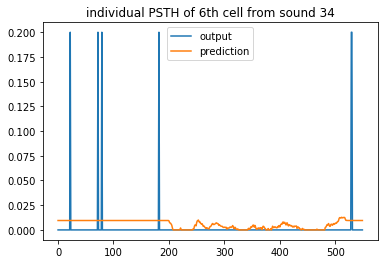

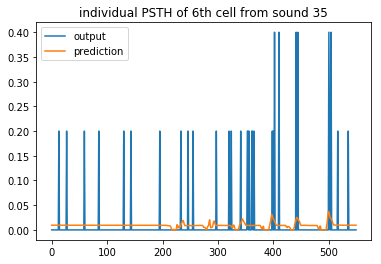

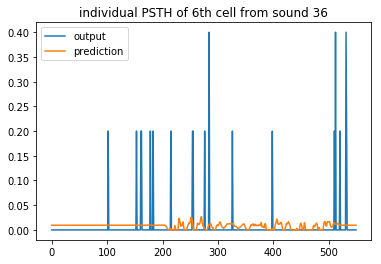

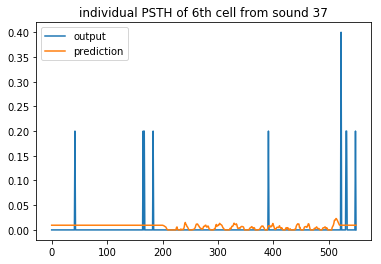

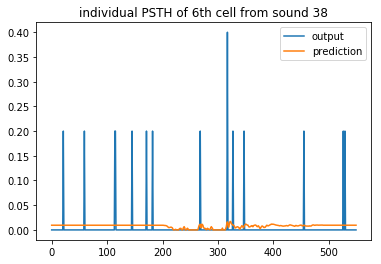

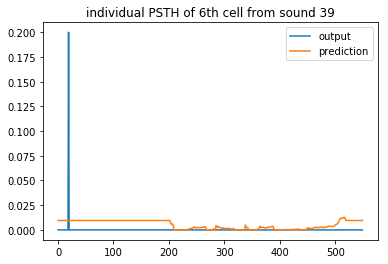

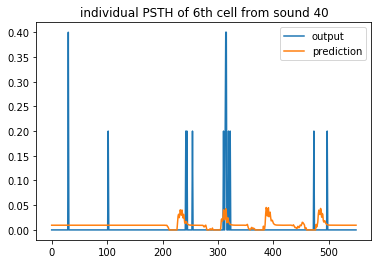

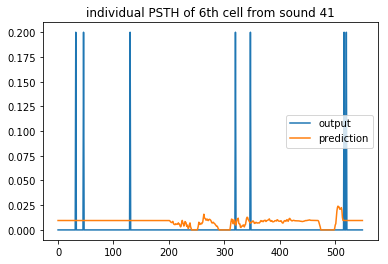

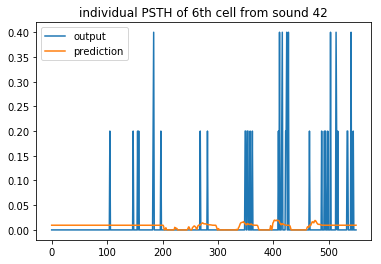

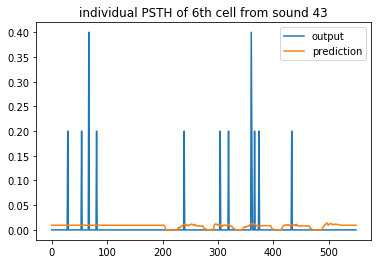

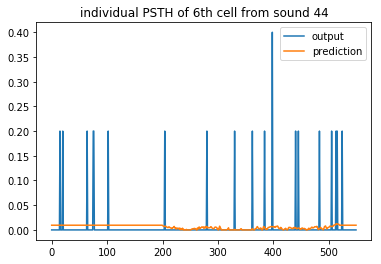

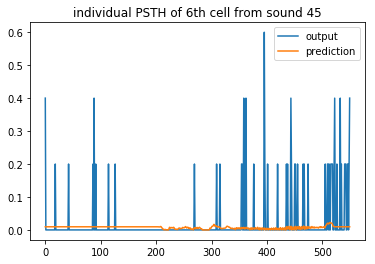

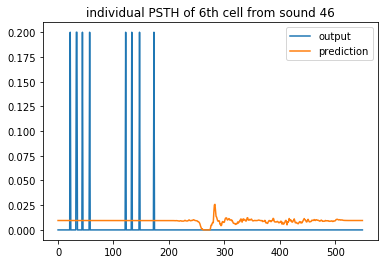

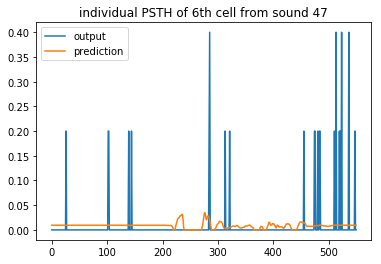

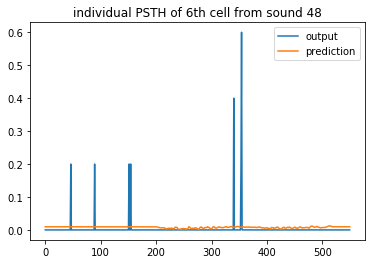

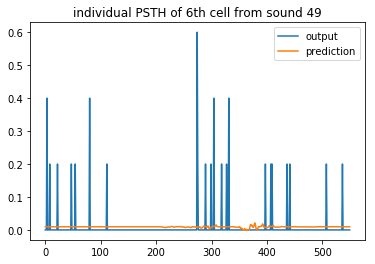

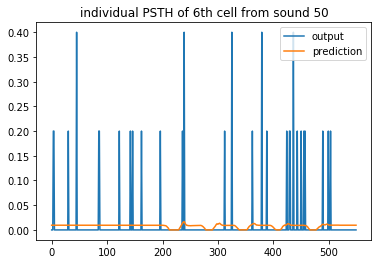

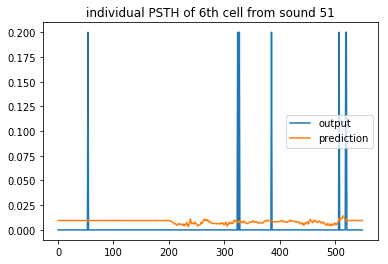

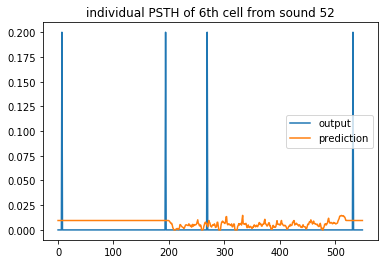

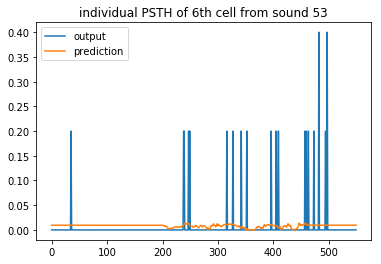

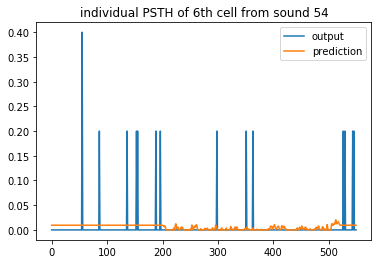

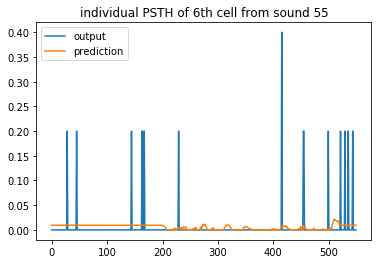

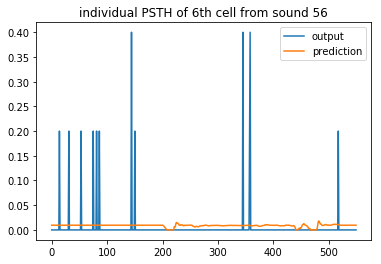

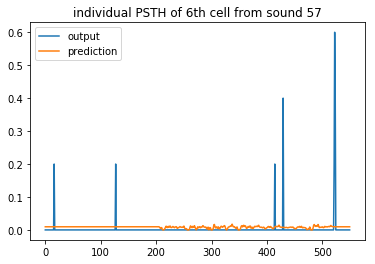

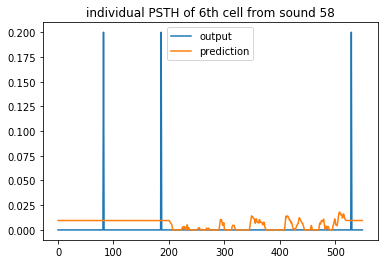

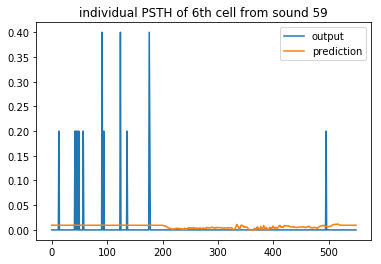

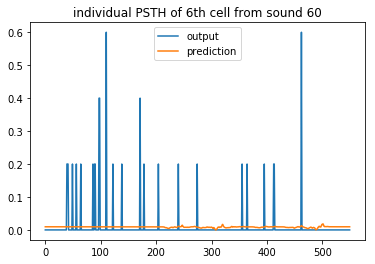

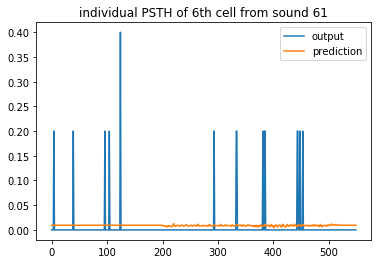

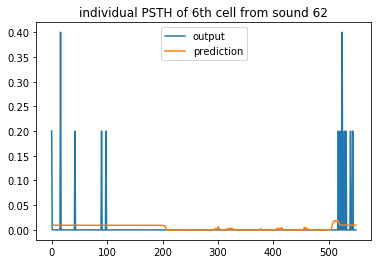

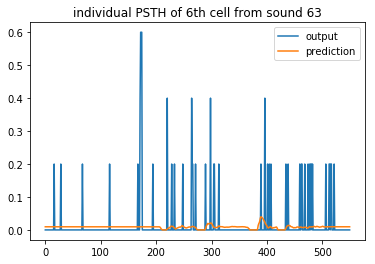

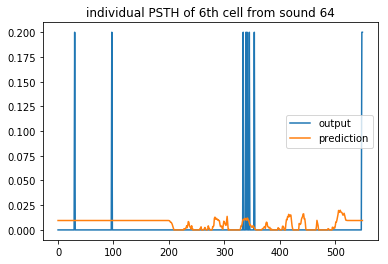

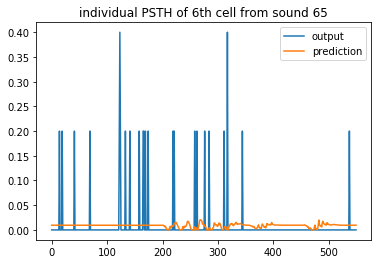

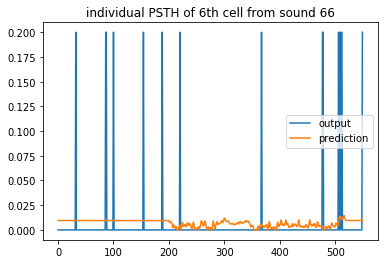

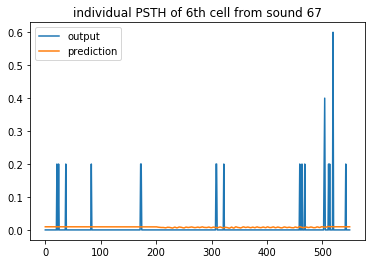

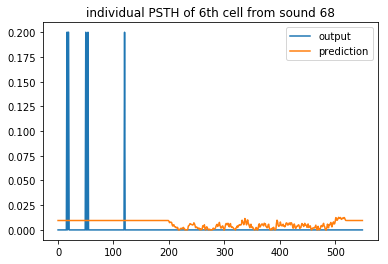

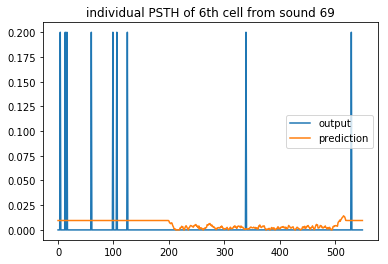

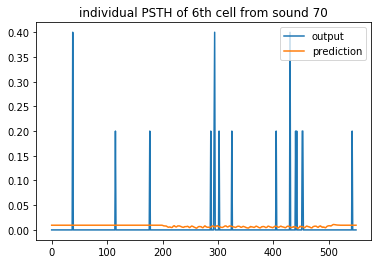

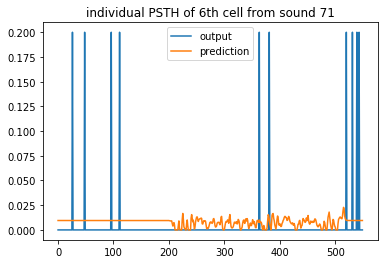

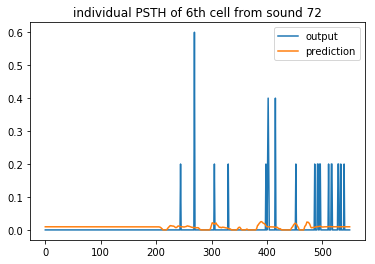

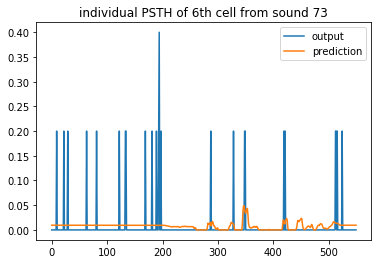

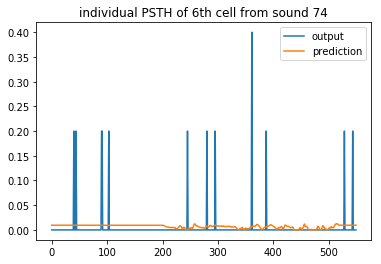

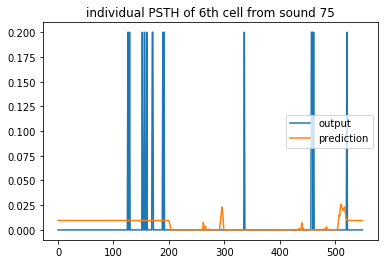

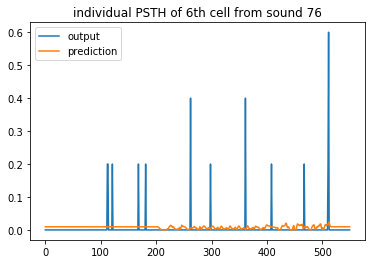

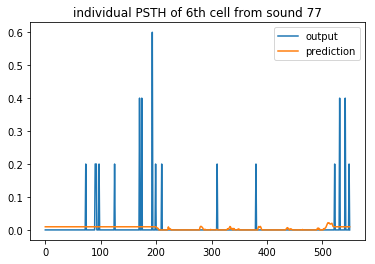

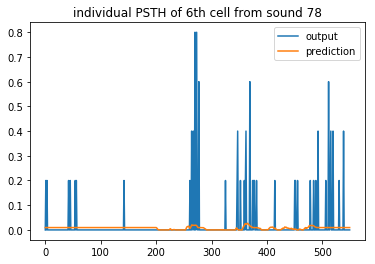

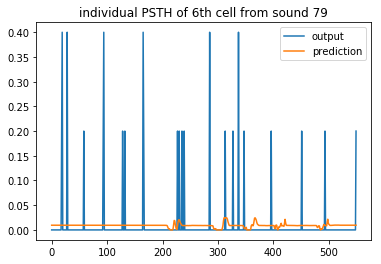

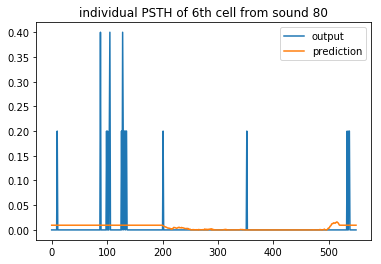

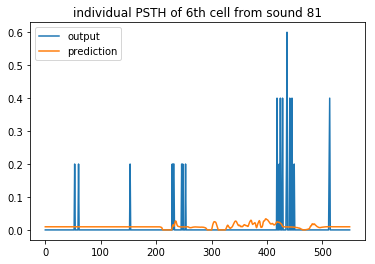

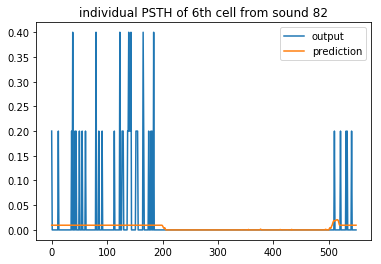

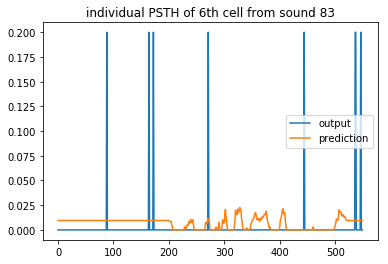

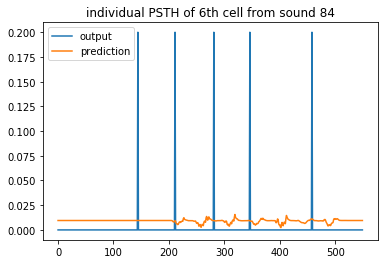

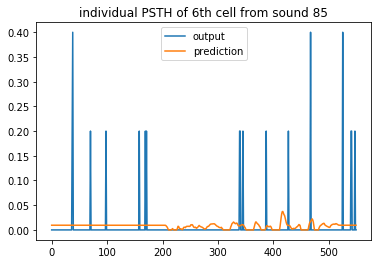

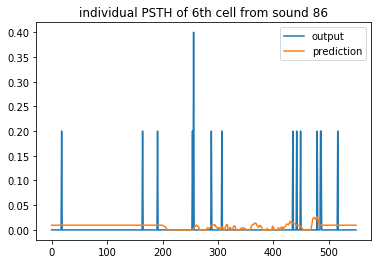

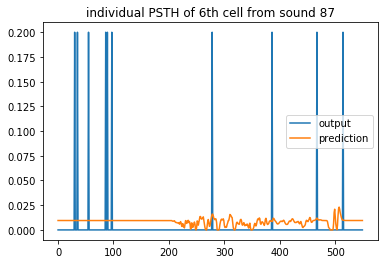

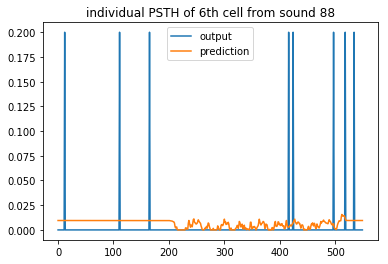

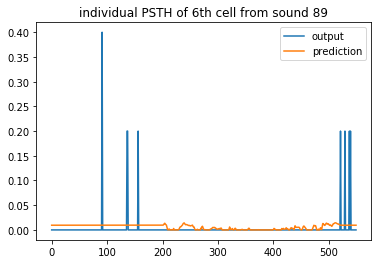

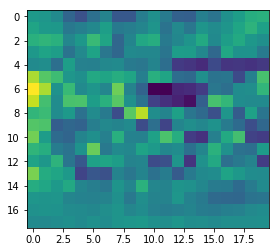

In [2]:
import os, io, re, scipy.io, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nems.utilities as nu
import nems.db as nd
import nems.utilities.baphy
from f_pre_process import getInsOuts
from f_conv1D_model import mk_and_fit_conv1Dmodel,prediction_score_and_plots

parmfilepath='/auto/data/daq/Tartufo/TAR010/TAR010c16_p_NAT.m'

options={'rasterfs': 100, 'includeprestim': True, 'stimfmt': 'ozgf', 'chancount': 18, 'cellid': 'all', 'pupil': True}
event_times, spike_dict, stim_dict, state_dict = nu.baphy.baphy_load_recording(parmfilepath,options)
cellidx = 6
time_window = 20

#from f_pre_process import getTrainTestTimes
#Train_times, TestTimes = getTrainTestTimes(event_times,3,24)
#event_name = TestTimes['name'][0]
#ff = (event_times['name']==event_name)
#event_times
results_pers = {}

for cellidx in [cellidx]: # range(1):
    X,Y,W,Z,t_12 = getInsOuts(cellidx,event_times,options['rasterfs'],stim_dict,spike_dict,False)
    #cellidx,event_times,fs_spectro,stim_dict,spike_dict,boolFigure=False

    model,history = mk_and_fit_conv1Dmodel(X,Y,1000,40,time_window,[0,0.001],0.005,'relu','poisson','SGD',0.2,False)
    predicted = model.predict(W)
    predicted_fit = model.predict(X)
    #Z.shape

    score = prediction_score_and_plots(model,X,Y,W,Z,t_12,predicted,history,cellidx,time_window,onTest=True,fig = True)
    score_fit = prediction_score_and_plots(model,X,Y,W,Z,t_12,predicted_fit,history,cellidx,time_window,onTest=False,fig = True)
    results_pers[list(spike_dict.keys())[cellidx]] = (score_fit,score)

save = False
if save:
    # SAVE MODEL
    config = model.get_config()[0]
    print(config)
    save_name = config['class_name'] + '_'  + config['config']['activation'] + '_compiler-' + \
        loss + '-' + str(lr) + '_'+ '_ker-' + \
        str(config['config']['kernel_initializer']['config']['minval']) + '-' + \
        str(config['config']['kernel_initializer']['config']['maxval']) + '_' + \
        'epochs-' + str(epochs) + '_batch-' + str(batch_size) 

    model.save('STRF_computation/models_trained/' + save_name)

In [ ]:
run f_conv1D_model.py

In [ ]:
# Compare Models

import math 

comp_mat_test = np.zeros((55,2))
comp_mat_train = np.zeros((55,2))
for i in range(55):
    my_train = results_pers[list(results_pers.keys())[i]][0]
    my_test =results_pers[list(results_pers.keys())[i]][1]
    my_train2 = steph_pred[list(steph_pred.keys())[i]][0]
    my_test2 = steph_pred[list(steph_pred.keys())[i]][1]
    
    comp_mat_train[i,:] = [my_train,my_train2]
    comp_mat_test[i,:] = [my_test,my_test2]
 
#plt.scatter(comp_mat_test)
fig = plt.figure()
plt.title('Test set correlation comparison_20')
plt.scatter(comp_mat_test[:,0],comp_mat_test[:,1])
plt.plot((0,1),(0,1),'--')
plt.xlabel('Alexis STRF ')
plt.ylabel('Stephen STRF ')
fig.text(0.6, 0.4, 'S_mean : 0.3954', fontsize=13)
fig.text(0.6, 0.3, 'A_mean : 0.3603', fontsize=13)
fig.savefig('Test_correlation_comparison_w20.pdf')

fig = plt.figure()
#fig,ax = plt.subplots()
plt.title('Train set correlation comparison_w20')
plt.scatter(comp_mat_train[:,0],comp_mat_train[:,1])
plt.plot((0,1),(0,1),'--')
plt.xlabel('Alexis STRF')
plt.ylabel('Stephen STRF')
fig.text(0.6, 0.4, 'S_mean : 0.2725', fontsize=13)
fig.text(0.6, 0.3, 'A_mean : 0.2033', fontsize=13)
#for i,n in enumerate(comp_mat_train):
#    if math.isnan(n[0])==0 and math.isnan(n[1])==0:
#        ax.annotate(i,([n[0],n[1]]))    
fig.savefig('Train_correlation_comparison_w20.pdf')

print('Stephen test/train mean corr : {} / {}'.format(np.nanmean(comp_mat_test[:,1]),np.nanmean(comp_mat_train[:,1])))
print('Alexis test/train mean corr : {} / {}'.format(np.nanmean(comp_mat_test[:,0]),np.nanmean(comp_mat_train[:,0])))

In [ ]:
## Compare Stephen and Alexis

import math 

comp_mat_test = np.zeros((55,2))
comp_mat_train = np.zeros((55,2))
for i in range(55):
    my_train = results_pers[list(results_pers.keys())[i]][0]
    my_test =results_pers[list(results_pers.keys())[i]][1]
    steph_train = steph_pred[list(results_pers.keys())[i]][0]
    steph_test = steph_pred[list(results_pers.keys())[i]][1]
    
    comp_mat_train[i,:] = [my_train,steph_train]
    comp_mat_test[i,:] = [my_test,steph_test]
 
#plt.scatter(comp_mat_test)
fig = plt.figure()
plt.title('Test set correlation comparison')
plt.scatter(comp_mat_test[:,0],comp_mat_test[:,1])
plt.plot((0,1),(0,1),'--')
plt.xlabel('Alexis STRF')
plt.ylabel('Stephen STRF')
fig.text(0.6, 0.4, 'S_mean : 0.3954', fontsize=13)
fig.text(0.6, 0.3, 'A_mean : 0.3332', fontsize=13)
#fig.savefig('Test_correlation_comparison.pdf')

fig = plt.figure()
fig,ax = plt.subplots()
plt.title('Train set correlation comparison')
plt.scatter(comp_mat_train[:,0],comp_mat_train[:,1])
plt.plot((0,1),(0,1),'--')
plt.xlabel('Alexis STRF')
plt.ylabel('Stephen STRF')
fig.text(0.6, 0.4, 'S_mean : 0.2725', fontsize=13)
fig.text(0.6, 0.3, 'A_mean : 0.1902', fontsize=13)
for i,n in enumerate(comp_mat_train):
    if math.isnan(n[0])==0 and math.isnan(n[1])==0:
        ax.annotate(i,([n[0],n[1]]))
    
fig.savefig('Train_correlation_comparison.pdf')

print('Stephen test/train mean corr : {} / {}'.format(np.nanmean(comp_mat_test[:,1]),np.nanmean(comp_mat_train[:,1])))
print('Alexis test/train mean corr : {} / {}'.format(np.nanmean(comp_mat_test[:,0]),np.nanmean(comp_mat_train[:,0])))

In [ ]:
steph_pred = {
'TAR010c-02-1' : (0.219623777864376,0.225943648744851),
'TAR010c-07-1' : (0.209240936394074,0.454496925615571),
'TAR010c-09-1' : (0.354612576058464,0.544614450452308),
'TAR010c-11-1' : (0.215498508118099,0.502315359824066),
'TAR010c-12-1' : (0.240105813799454,0.170833544672807),
'TAR010c-13-1' : (0.688178363633957, 0.84080233152105),
'TAR010c-15-1' : (0.089681258030378,0.201420078997915),
'TAR010c-15-2' : (0.530999046108094,0.721607277581847),
'TAR010c-15-3' : (0.169632549539111,0.473755298499032),
'TAR010c-16-1' : (0.182771871650416,0.249577643213657),
'TAR010c-16-2' : (0.465673759458119,0.527840297880115),
'TAR010c-18-1' : (0.426284980329072,0.596698278703753),
'TAR010c-19-1' : (0.299766686058647,0.429738662668912),
'TAR010c-20-1' : (0.464471001769272,0.632515268475058),
'TAR010c-20-2' : (0.126117234018656,0.270381520728528),
'TAR010c-21-1' : (0.330413915664342,0.586664105379994),
'TAR010c-21-2' : (0.661325768608662,0.824181866153898),
'TAR010c-23-1' : ( 0.20214239834829,0.392360997203071),
'TAR010c-24-1' : ( 0.32339905010357,0.242127657922396),
'TAR010c-24-2' : (0.247919698974803,0.207555991034509),
'TAR010c-27-1' : (0.217989168388459,0.274387774233371),
'TAR010c-29-1' : ( 0.58153126492243, 0.41014694698522),
'TAR010c-30-1' : ( 0.47266692203556, 0.72375122029293),
'TAR010c-33-1' : (0.0955057490309024,0.194514723010389),
'TAR010c-33-2' : (0.551445868770204,0.587035387873126),
'TAR010c-35-1' : (0.339915258527375,0.274626242374267),
'TAR010c-36-1' : (0.515267288577141,0.543821779234812),
'TAR010c-36-2' : (0.555545321073088,0.523585393851477),
'TAR010c-36-3' : (0.189286996312301,0.335456553255533),
'TAR010c-38-1' : (0.363431088871435,0.632035468625684),
'TAR010c-40-1' : (0.477794747666548,0.736816334826353),
'TAR010c-42-1' : (0.161776575870462,0.358037190691179),
'TAR010c-42-2' : (0.213478454731309,0.428793808564934),
'TAR010c-43-1' : (0.386487061729104, 0.65094972084573),
'TAR010c-45-1' : (0.160137558528086,0.438589527106701),
'TAR010c-45-2' : (0.114945162464512,0.245227702666235),
'TAR010c-45-3' : (0.101604055953994,  0.1802341578329),
'TAR010c-47-1' : (0.0928457513774624,0.306358917864527),
'TAR010c-50-1' : ( 0.10423148711147,0.162936979779327),
'TAR010c-50-2' : (0.110599851472106, 0.21367215256135),
'TAR010c-51-1' : (0.246324473879483,0.311695591138644),
'TAR010c-52-1' : (0.135116761064946,0.238454339845473),
'TAR010c-52-2' : (0.0526939682108476,  0.1053072822433),
'TAR010c-53-1' : ( 0.18612514248074,0.449399466582281),
'TAR010c-54-1' : (0.114200334617505,0.282760192562163),
'TAR010c-55-1' : (0.241955948512882,0.518358579086875),
'TAR010c-57-1' : (0.337945125669743,0.369389068884475),
'TAR010c-57-2' : (  0.1253205609133,0.223414417225662),
'TAR010c-58-1' : (0.143537680280749,0.160402273710019),
'TAR010c-58-2' : (0.131248966905983,0.226991528005784),
'TAR010c-58-3' : (0.251369252528246,0.539765950442705),
'TAR010c-59-1' : (0.256709248820301,0.391656391971534),
'TAR010c-60-1' : (0.256427126478954,0.225497619270426),
'TAR010c-63-1' : (0.132893112652454,0.189982903196278),
'TAR010c-64-1' : (0.118775511490653,0.197946046657936)}